In [268]:
# standard library
from collections import Counter, defaultdict
import pickle
import random

# 3rd party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

![](http://www.kwhanalytics.com/wp-content/uploads/2018/01/kWh_share_logo.jpg)

----
# ToDo: continue writing up/cleaning up the notebook for presentation 
# ToDo write a short bash script that will spin up a Ec2 instance, install packages, and deploy Dash app 

# Online Analytical Dashboard 

The **goal** is build a prototype analytical dashboard for solar energy consumers. 

This is our scenario: imagine that one of Google's locations (there are many in the USA) has 4 buildings, each with solar panel installations. They want to keep track of 3 very importannt trends: 

1. Energy Consumption by each building
2. Energy Production by each building
3. Energy cost/profit by each building

The numbers will be tracked monthly. The cost is the energy bill for each building, so that means that the building has consumed more energy than its solar panels produced. The profit is the money made by selling excess energy back to the energy grid. In the end, we will have one years worth of data for each building. 

In [2]:
# load data
df = pd.read_csv('datasci_takehome.csv')
df_house = pd.read_csv('household_power_consumption.txt', delimiter=";")

/Users/databeast03/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----
### Clean and Format Energy Consumption Data

In order to simulate the energy consumption from these buildings, we are going to use the household consuption data: an open source data set available at the [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption). 

In [3]:
df_house = df_house[df_house.columns[:3]]
df_house['Date'] = pd.to_datetime(df_house['Date'])

In [4]:
df_house.head()

,Date,Time,Global_active_power
0,2006-12-16,17:24:00,4.216
1,2006-12-16,17:25:00,5.360
2,2006-12-16,17:26:00,5.374
3,2006-12-16,17:27:00,5.388
4,2006-12-16,17:28:00,3.666


In [5]:
def normalize_data_types(df, col):
    #Convert Series datatype to numeric, getting rid of any non-numeric values
    df[col] = pd.to_numeric(df[col], errors="coerce")   
    df.dropna(axis=0, inplace=True)
    return df

In [6]:
df_house = df_house[df_house.columns[:3]]
df_house['Date'] = pd.to_datetime(df_house['Date'])
df_house = normalize_data_types(df_house, "Global_active_power")

/Users/databeast03/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


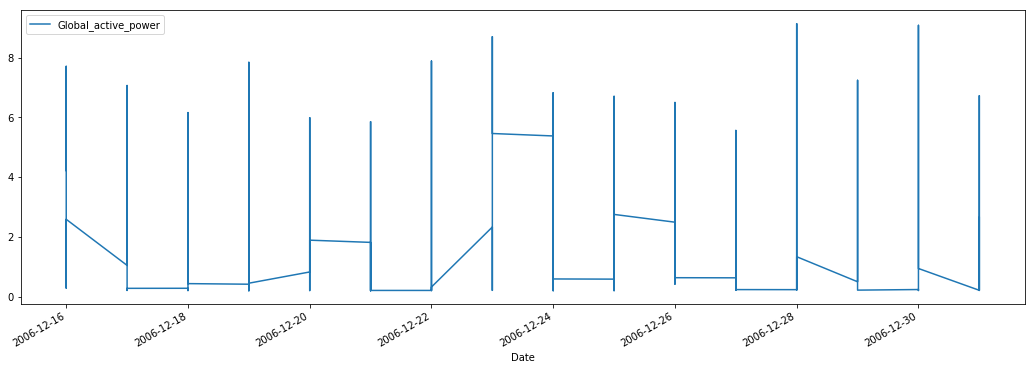

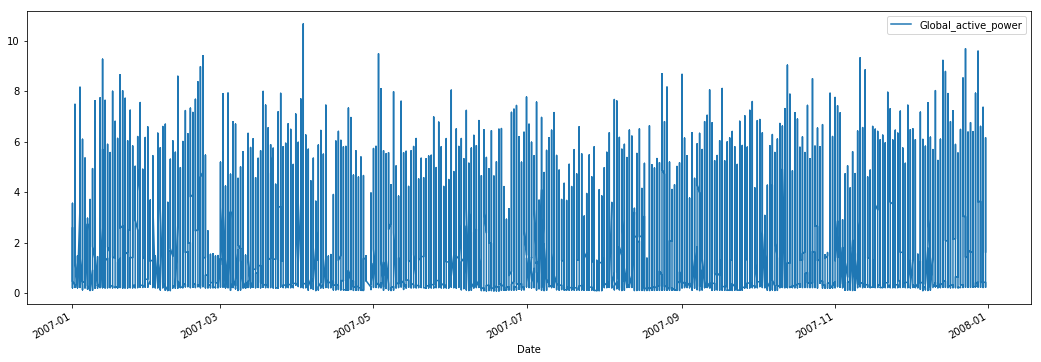

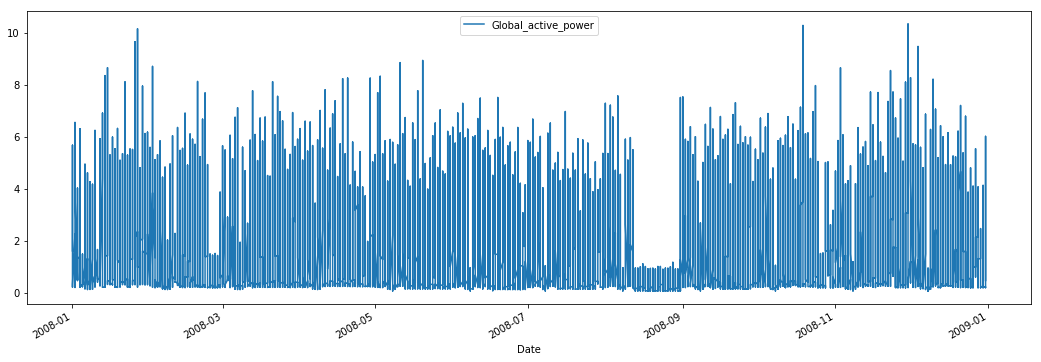

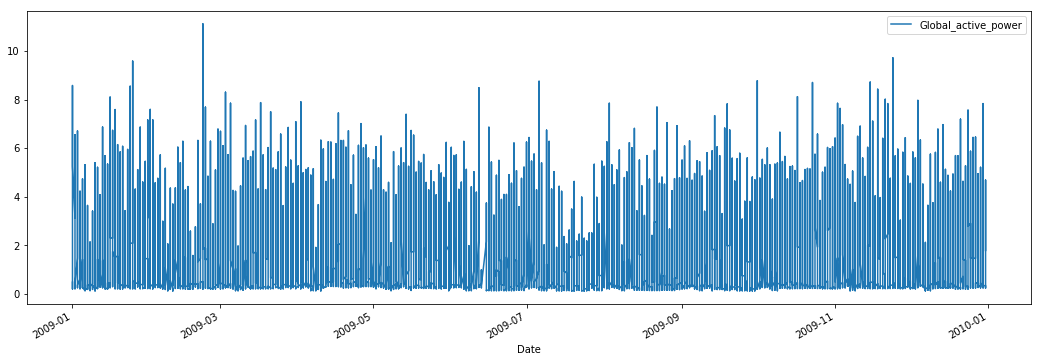

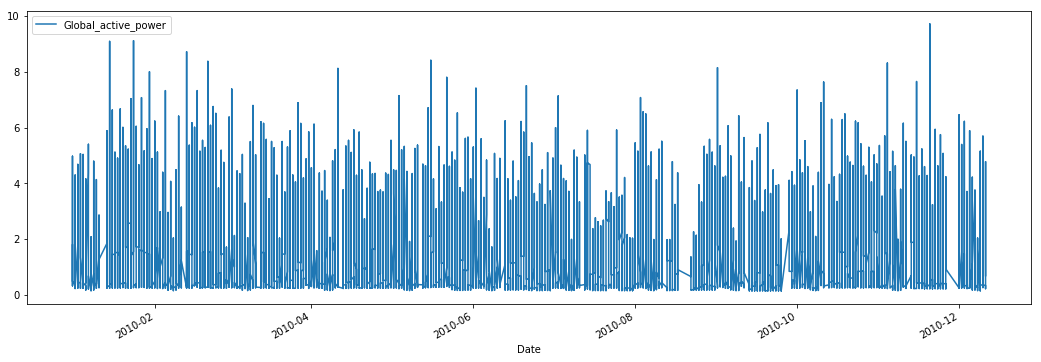

In [8]:
df_house.set_index('Date').groupby(pd.TimeGrouper('A')).plot(figsize = (18,6));

### About the Plots

This dataset has 4 complete years of energy consumption data, with a little extra in 2006 which we will ignore. The data is collected on a minute-by-minute basis by house sensors. We are going to aggragate the data so that we have monthly data points which we can use in combination with monthly energy production data that we'll explore shortly. 

In [9]:
df_house["year"]=df_house.Date.apply(lambda row: str(row).split("-")[0])
df_house["month"]=df_house.Date.apply(lambda row: str(row).split("-")[1])
df_house["day"]=df_house.Date.apply(lambda row: str(row).split("-")[2].split(" ")[0])

In [10]:
df_house.head()

,Date,Time,Global_active_power,year,month,day
0,2006-12-16,17:24:00,4.216,2006,12,16
1,2006-12-16,17:25:00,5.360,2006,12,16
2,2006-12-16,17:26:00,5.374,2006,12,16
3,2006-12-16,17:27:00,5.388,2006,12,16
4,2006-12-16,17:28:00,3.666,2006,12,16


In [11]:
daily_sum = df_house.groupby(by=["year", 'month', 'day'])[["Global_active_power"]].sum()
monthlhy_mean = daily_sum.groupby(by=['year',"month"])[["Global_active_power"]].mean()

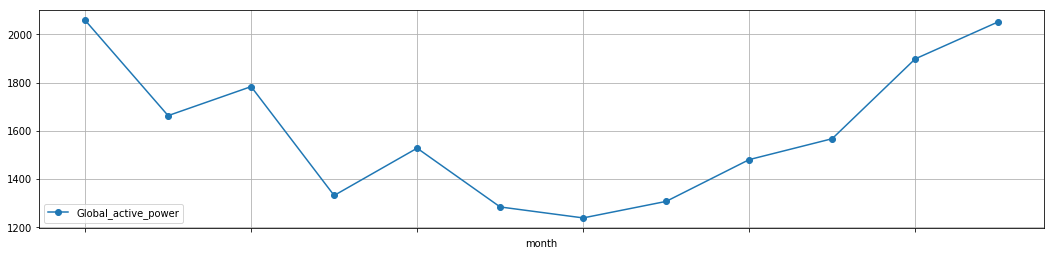

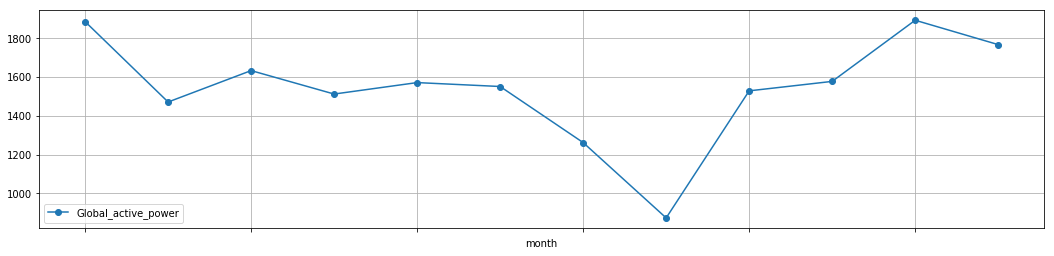

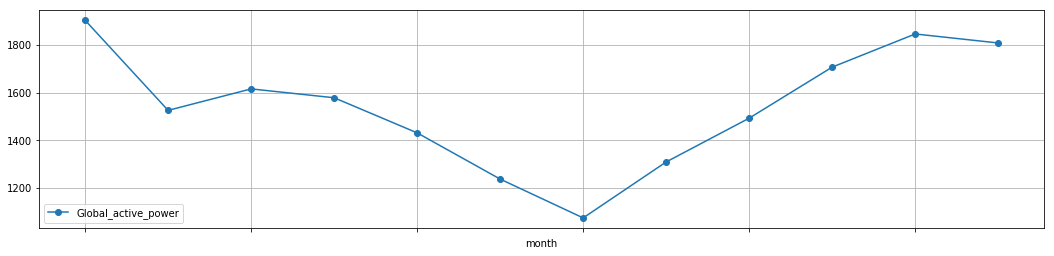

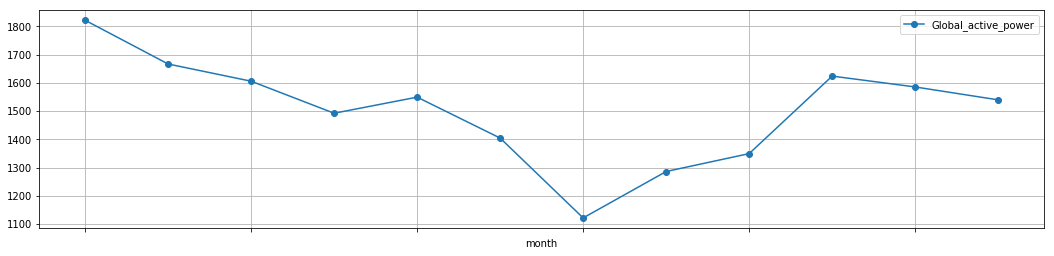

In [25]:
monthlhy_mean.T["2007"].T.plot(figsize=(18,4),grid=True, marker="o")
monthlhy_mean.T["2008"].T.plot(figsize=(18,4),grid=True, marker="o")
monthlhy_mean.T["2009"].T.plot(figsize=(18,4),grid=True, marker="o")
monthlhy_mean.T["2010"].T.plot(figsize=(18,4),grid=True, marker="o");

### About the Plots

These 4 plots are the **aggragated monthly energy consumption (in kWh)** that we'll use to model each of the 4 google building's energy consumption for one full year. 

----
### Model Consumption Data

Next we are going to training a machine learning model to forecast the energy consumption for the following month for each builidng. 

In [26]:
monthlhy_mean.reset_index(inplace=True)

In [27]:
monthlhy_mean.month=monthlhy_mean.month.astype("int")

In [28]:
month_energy = monthlhy_mean[monthlhy_mean.columns[2:4]][1:]

In [48]:
energy = month_energy.T.values[0]

In [50]:
np.mean(energy), np.median(energy)

(1547.756481437145, 1550.2407666666668)

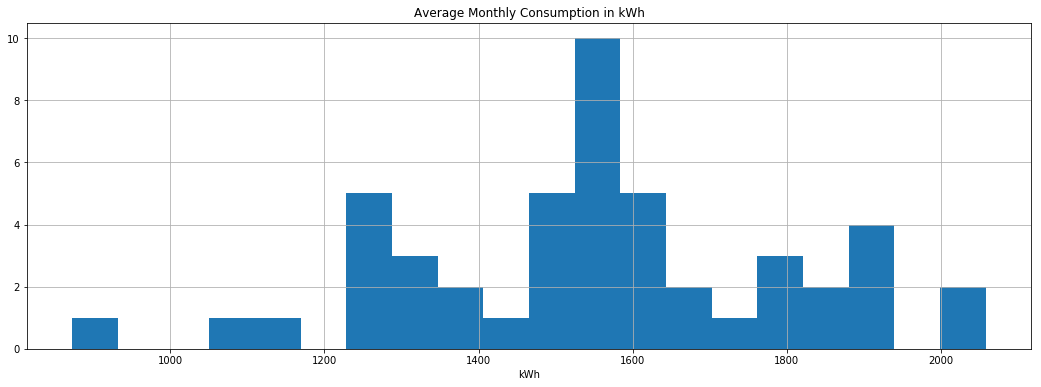

In [52]:
plt.figure(figsize = (18,6))
plt.title("Average Monthly Consumption in kWh")
plt.hist(energy, bins=20);
plt.xlabel("kWh")
plt.grid();

In [280]:
# we are going to move the last data point of each year (for each building) to a test set
# the first 11 months of each year (for each builidng) is moved to the train set
# the model will be simple it will forecast a month ahead based on the current month's value
# for our prototype purposes, this is sufficient
# for production, we would likly seek a more sophisticated and better performing approach 
x_test = []
y_test = []
test_set = []
train_set=[]
for ind, val in enumerate(energy):
    if ind%11 == 0 and ind != 0:
        y_test.append(val)
        
    elif ind%10 == 0 and ind!=0:
        x_test.append(val)
        train_set.append(val)
        
    else:
        train_set.append(val)  
        
train_set = np.array(train_set)
test_set = np.array(test_set)
x_test = np.array(x_test).reshape((-1,1))
y_test = np.array(y_test)

In [281]:
def create_dataset(dataset, look_back, look_ahead):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_ahead):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_ahead])
	return dataX, dataY

In [282]:
look_back=1
look_ahead=1
x_train, y_train = create_dataset(train_set, look_back, look_ahead)

In [283]:
# sanity check on the test set
for index, val in enumerate(energy):
    if index %10==0 and index !=0:
        print ("This is the 11th month {}".format(val))
    if index %11==0 and index !=0:
        print ("This is the 12th month {}".format(val))

This is the 11th month 1897.876733333333
This is the 12th month 2051.2561290322574
This is the 11th month 1528.7423333333334
This is the 12th month 1893.0516666666663
This is the 11th month 1075.4001290322585
This is the 12th month 1706.1347096774196
This is the 11th month 1549.3421333333338
This is the 12th month 1349.3776296296294


In [284]:
x_test

array([[1897.87673333],
       [1528.74233333],
       [1075.40012903],
       [1549.34213333]])

In [285]:
y_test

array([2051.25612903, 1893.05166667, 1706.13470968, 1349.37762963])

In [286]:
test_size = len(y_test)
train_mean = np.mean(x_train)
navie_y_hat = np.linspace(train_mean,train_mean,test_size)

In [301]:
# navie baseline results
print(mean_squared_error(y_test, navie_y_hat))
print(mean_absolute_error(y_test, navie_y_hat))
print(r2_score(y_test, navie_y_hat))

117172.08386233899
310.69897716739
-0.7127825282883373


In [302]:
lr = LinearRegression()
lr.fit(x_train, y_train);
y_hat_train = lr.predict(x_train)
y_hat_test = lr.predict(x_test)

# Linear Regression results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

116488.59976716846
329.3701145062532
-0.7027915852413025


In [315]:
param_grid = {
    "learning_rate":[0.1, 0.01, 0.001],
      "n_estimators":[10, 100], 
    "min_samples_split":[2,4,6], 
    "max_depth":[3,5,7]    
}

gbt = GradientBoostingRegressor()
gs = GridSearchCV(gbt, param_grid, n_jobs=-1)
gs.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [10, 100], 'min_samples_split': [2, 4, 6], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [316]:
gbt = gs.best_estimator_
gbt.fit(x_train, y_train);
y_hat_train = gbt.predict(x_train)
y_hat_test = gbt.predict(x_test)

# GBR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

124837.76402210182
332.2500440994348
-0.8248368898077063


In [312]:
gbt = GradientBoostingRegressor()
gbt.fit(x_train, y_train);
y_hat_train = gbt.predict(x_train)
y_hat_test = gbt.predict(x_test)

# GBR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

84211.49202816801
258.7560314870056
-0.2309755657874628


In [305]:
param_grid = {
    "n_estimators":[10, 100, 1000], 
    "min_samples_split":[2,4,6], 
    "max_depth":[3,5,7]    
}

rfr = RandomForestRegressor(criterion='mae')
gs_rfr = GridSearchCV(rfr, param_grid, n_jobs=-1)
gs_rfr.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 1000], 'min_samples_split': [2, 4, 6], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [317]:
rfr = gs_rfr.best_estimator_
rfr.fit(x_train, y_train);
y_hat_train = rfr.predict(x_train)
y_hat_test = rfr.predict(x_test)

# RFR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

123476.34391810751
339.45500886637245
-0.8049361037935092


In [318]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(x_train, y_train);
y_hat_train = rfr.predict(x_train)
y_hat_test = rfr.predict(x_test)

# RFR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

106582.50754979393
300.72370406469344
-0.5579876258488414


### Model Results

It's interesting to note that the out-of-the-box models perform better than the gridsearched models. This seems to imply that we didn't include enough hyperparameters and possible values in our param_dict. Which is fine for our purposes, which is to deploy a prototype data product on the cloud. In an actual startup environment, much more time would be spent on building the best possible performing model for the given task. 

In [321]:
gbt = GradientBoostingRegressor()
gbt.fit(x_train, y_train);
y_hat_train = gbt.predict(x_train)
y_hat_test = gbt.predict(x_test)

# GBR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

84211.49202816801
258.7560314870056
-0.2309755657874628


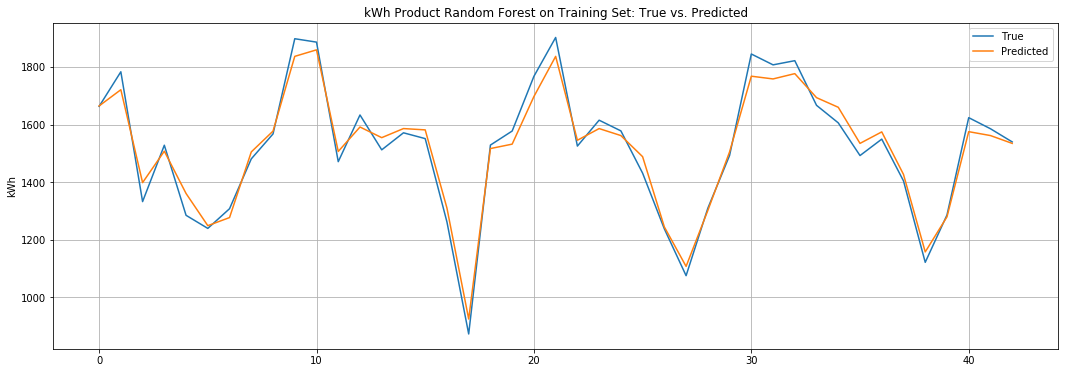

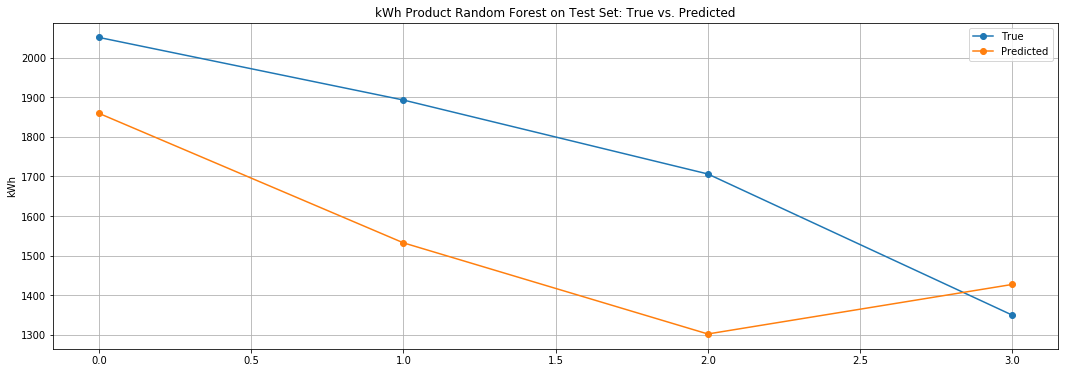

In [322]:
plt.figure(figsize=(18,6))
plt.title("kWh Product Random Forest on Training Set: True vs. Predicted")
plt.grid()
plt.ylabel("kWh")
plt.plot(y_train, label="True")
plt.plot(y_hat_train, label="Predicted");
plt.legend();

plt.figure(figsize=(18,6))
plt.title("kWh Product Random Forest on Test Set: True vs. Predicted")
plt.grid()
plt.ylabel("kWh")
plt.plot(y_test, '-o', label="True")
plt.plot(y_hat_test, '-o', label="Predicted");
plt.legend();

### Save Trained Model


In [323]:
consumption_model_filename = "trained_model_consumption_forecast.pkl"
pickle.dump(gbt, open(consumption_model_filename, 'wb'))

-----
### Format Production Data

In [324]:
df["performance_ratio"] = df.correctedkwh/ df.expectedkwh

In [325]:
df.head()

,system,vintage,month,correctedkwh,expectedkwh,performance_ratio
0,0,A,1,173.529653,198.540076,0.874028
1,0,A,2,813.983258,713.864260,1.140249
2,0,A,3,1165.037521,1008.230599,1.155527
3,0,A,4,1375.705546,1207.557369,1.139247
4,0,A,5,1550.371246,1381.366075,1.122346


811.0770269999999

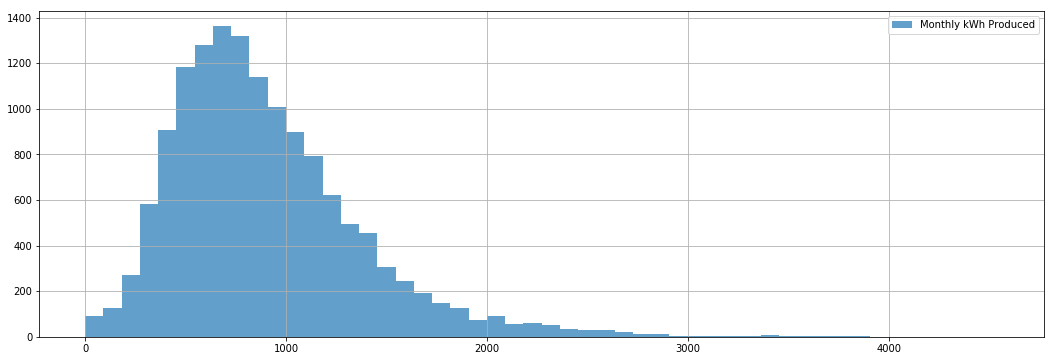

In [326]:
df.correctedkwh.hist(figsize = (18,6), bins=50, alpha=0.7, label="Monthly kWh Produced")
plt.legend();
df.correctedkwh.median()

In [235]:
# let use vintage 'C' since that vintage appears in larger numbers 
# thus we'll have a much larger data set to train our model with
df.groupby(by=["vintage"])[["vintage"]].count()

,vintage
vintage,
A,902
B,5372
C,7795


In [236]:
# this groupby statement shows that not all systems have a data point for all 12 months 
# this means that we'll have to filter out the systems that are incomplete
df.groupby(by=["vintage", 'month'])[["month"]].count()

month
vintage month       
A       1          1
        2          4
        3         10
        4         12
        5         16
        6         35
        7         54
        8         66
        9        106
        10       149
        11       203
        12       246
B       1        286
        2        317
        3        358
        4        392
        5        416
        6        448
        7        482
        8        501
        9        518
        10       538
        11       547
        12       569
C       1        579
        2        596
        3        626
        4        640
        5        659
        6        665
        7        671
        8        672
        9        672
        10       672
        11       672
        12       671

In [327]:
df_C = df[df.vintage =="C"]

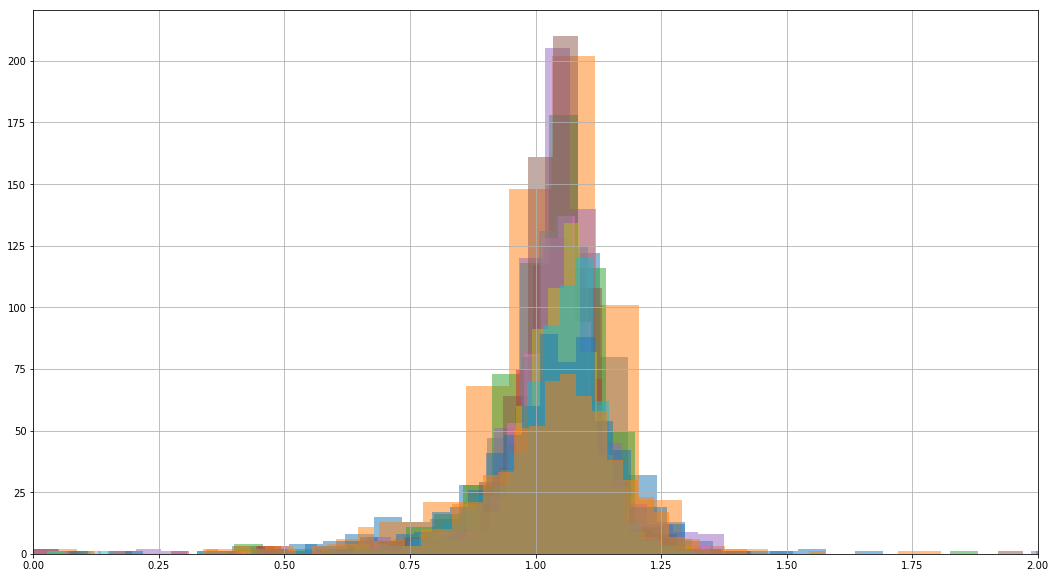

In [328]:
# distribution of peformance ratios for all systems of vintage 'C'
df_C.groupby(by="month")["performance_ratio"].hist(figsize=(18,10), 
                                                   bins=40, 
                                                   alpha=0.5);
plt.xlim((0,2.0));

In [329]:
groupby = df_C.groupby(by="month")["performance_ratio"]

In [330]:
groupby.describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,579.0,1.034174,0.168634,0.058148,0.971434,1.060355,1.122313,2.311561
2,596.0,1.035014,0.174219,0.000184,0.974021,1.048237,1.110833,3.443744
3,626.0,1.031486,0.139173,0.000144,0.976867,1.042486,1.094170,2.281241
4,640.0,1.024782,0.111418,0.000122,0.993620,1.041639,1.083069,1.373262
5,659.0,1.036845,0.144081,0.000132,1.002878,1.046916,1.089565,2.036848
6,665.0,1.026731,0.133711,0.000019,0.998358,1.043579,1.082111,1.970518
7,671.0,1.029247,0.119921,0.000019,0.995201,1.044746,1.083389,1.347055
8,672.0,1.027757,0.106933,0.022384,0.998659,1.043595,1.082860,1.334194
9,672.0,1.030021,0.115063,0.026299,0.991611,1.048793,1.089730,1.314985


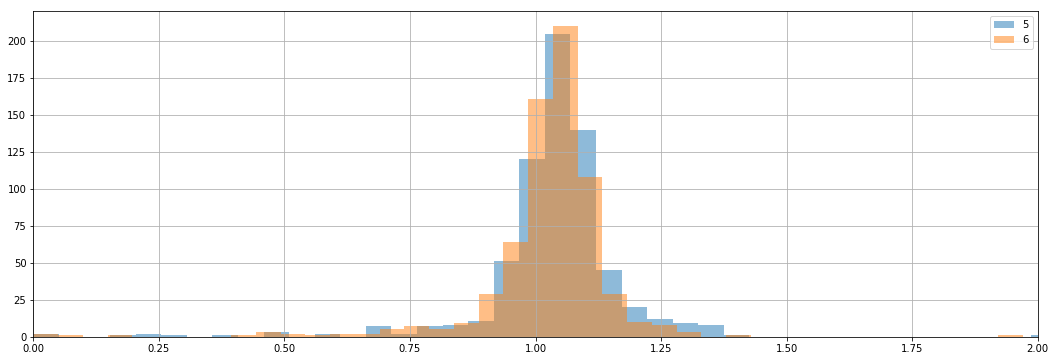

In [331]:
# assuming Northern Hemisphere 
# summer months
df_C[df_C.month == 5]["performance_ratio"].hist(figsize = (18,6), 
                                                bins=40, 
                                                alpha=0.5, 
                                                label = "5");

df_C[df_C.month == 6]["performance_ratio"].hist(figsize = (18,6), 
                                                bins=40, 
                                                alpha=0.5, 
                                                label = "6");
plt.xlim((0,2.0));
plt.legend();

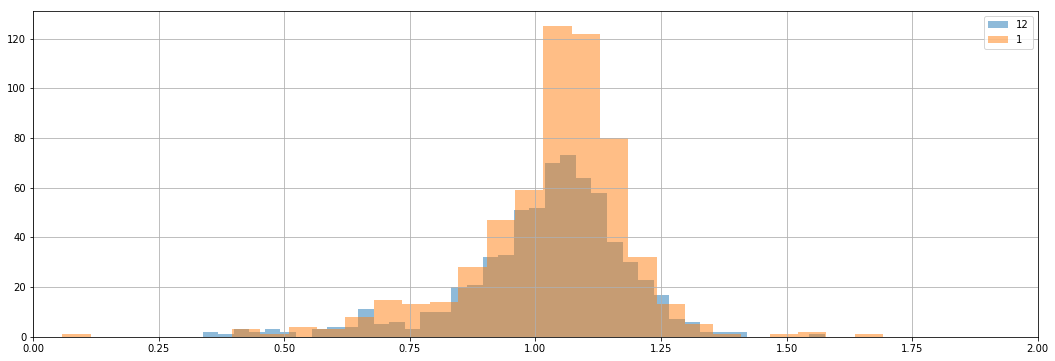

In [332]:
# assuming Northern Hemisphere
# winter months 
df_C[df_C.month == 12]["performance_ratio"].hist(figsize = (18,6), 
                                                 bins=40, 
                                                 alpha=0.5, 
                                                 label="12");

df_C[df_C.month == 1]["performance_ratio"].hist(figsize = (18,6), 
                                                bins=40, 
                                                alpha=0.5, 
                                                label="1");
plt.xlim((0,2.0));
plt.legend();

In [335]:
df_C.head(15)

,system,vintage,month,correctedkwh,expectedkwh,performance_ratio
24,2,C,1,767.402852,679.073239,1.130074
25,2,C,2,840.066448,703.870161,1.193496
26,2,C,3,1120.767545,994.115370,1.127402
27,2,C,4,1327.140916,1190.651566,1.114634
28,2,C,5,1483.028449,1362.026950,1.088839
29,2,C,6,1405.917037,1290.511319,1.089426
30,2,C,7,1380.965377,1259.649346,1.096309
31,2,C,8,1324.285708,1201.071595,1.102587
32,2,C,9,1153.135344,1022.468308,1.127796
33,2,C,10,1016.964143,882.447488,1.152436


In [340]:
np.sum(range(1,13))

78

In [341]:
# every system with 12 months will have a annual month sum to 78
sum_of_1_though_12 = np.sum(range(1,13))


full_12_months_mask = df_C.groupby(by=["system"])["month"].sum() == sum_of_1_though_12
full_12_months_agg = full_12_months_mask.reset_index()

# drop nans
full_12_months_agg=full_12_months_agg.where(full_12_months_agg.month == True).dropna()
df_merge = df_C.merge(full_12_months_agg, how="inner", on="system" )
productin_data = df_merge[["month_x", "correctedkwh"]]

In [342]:
def format_data(df):
    master_train= []
    test = []
    temp = []
    for index, row in df[["month_x", "correctedkwh"]].iterrows():
        if row[0] == 12:
            master_train.append(temp)
            test.append(row[1])
            temp = []

        else:
            temp.append(row[1])


    master_train = np.array(master_train)
    test = np.array(test)
    
    return master_train, test

In [343]:
master_train, test = format_data(productin_data)

In [344]:
master_train[0]

array([ 767.402852,  840.066448, 1120.767545, 1327.140916, 1483.028449,
       1405.917037, 1380.965377, 1324.285708, 1153.135344, 1016.964143,
        811.987911])

In [345]:
test[0]

793.978961

In [346]:
# sanity check: the test value is the 12th value in a 12 month series for each system
# it's the 12th month that we will be prodicting
productin_data[0:12]

,month_x,correctedkwh
0,1,767.402852
1,2,840.066448
2,3,1120.767545
3,4,1327.140916
4,5,1483.028449
5,6,1405.917037
6,7,1380.965377
7,8,1324.285708
8,9,1153.135344
9,10,1016.964143


In [347]:
split = 460
x_train = master_train[:split]
y_train = test[:split]
x_test = master_train[split:]
y_test = test[split:]

In [348]:
navie_mean = np.mean(x_test, axis=1)

In [349]:
# navie baseline results
print(mean_squared_error(y_test, navie_mean))
print(np.sqrt(mean_squared_error(y_test, navie_mean)))
print(mean_absolute_error(y_test, navie_mean))
print(r2_score(y_test, navie_mean))

145947.8737847978
382.0312471314327
347.69385100470225
-0.6138581702505979


In [350]:
lr = LinearRegression()
lr.fit(x_train, y_train);
y_hat = lr.predict(x_test)

# Linear Regression results
print(mean_squared_error(y_test, y_hat))
print(np.sqrt(mean_squared_error(y_test, y_hat)))
print(mean_absolute_error(y_test, y_hat))
print(r2_score(y_test, y_hat))

2644.6891028667665
51.42654084095844
35.30232412545224
0.9707556334617954


In [353]:
param_grid = {
    "learning_rate":[0.1, 0.01, 0.001],
      "n_estimators":[10, 100], 
    "min_samples_split":[2,4,6], 
    "max_depth":[3,5,7]    
}

gbt = GradientBoostingRegressor()
gs = GridSearchCV(gbt, param_grid, n_jobs=-1)
gs.fit(x_train, y_train);

In [354]:
gbt = gs.best_estimator_
gbt.fit(x_train, y_train);
y_hat_train = gbt.predict(x_train)
y_hat_test = gbt.predict(x_test)

# GBR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

5158.587173780982
44.54743473321265
0.9429575242073616


In [355]:
gbt = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100)
gbt.fit(x_train, y_train);
y_hat_train = gbt.predict(x_train)
y_hat_test = gbt.predict(x_test)

# GBR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

4546.3674060310595
43.18527863006149
0.9497273102175984


In [356]:
param_grid = {
    "n_estimators":[10, 100, 1000], 
    "min_samples_split":[2,4,6], 
    "max_depth":[3,5,7]    
}

rfr = RandomForestRegressor(criterion='mae')
gs_rfr = GridSearchCV(rfr, param_grid, n_jobs=-1)
gs_rfr.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 1000], 'min_samples_split': [2, 4, 6], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [357]:
rfr = gs_rfr.best_estimator_
rfr.fit(x_train, y_train);
y_hat_train = rfr.predict(x_train)
y_hat_test = rfr.predict(x_test)

# RFR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

4643.240297506949
43.696672757413744
0.9486561119648942


In [358]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rfr.fit(x_train, y_train);
y_hat_train = rfr.predict(x_train)
y_hat_test = rfr.predict(x_test)

# RFR results
print(mean_squared_error(y_test, y_hat_test))
print(mean_absolute_error(y_test, y_hat_test))
print(r2_score(y_test, y_hat_test))

4108.484004129235
42.710992541982804
0.9545693246125351


### Model Results

We see that it's Linear Regression that predicts energy production the best. So we'll move foreward with that model. 

In [362]:
lr = LinearRegression()
lr.fit(x_train, y_train);
y_hat = lr.predict(x_test)

# Linear Regression results
print(mean_squared_error(y_test, y_hat))
print(np.sqrt(mean_squared_error(y_test, y_hat)))
print(mean_absolute_error(y_test, y_hat))
print(r2_score(y_test, y_hat))

2644.6891028667665
51.42654084095844
35.30232412545224
0.9707556334617954


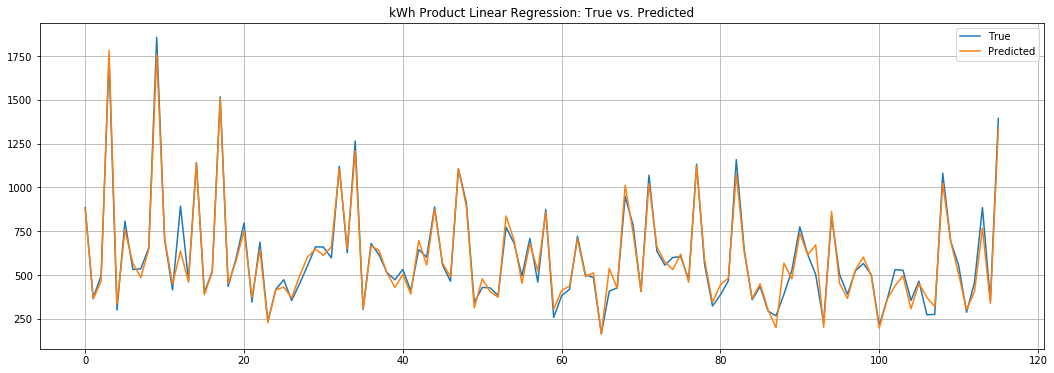

In [363]:
plt.figure(figsize=(18,6))
plt.title("kWh Product Linear Regression: True vs. Predicted")
plt.grid()
plt.plot(y_test, label="True")
plt.plot(y_hat, label="Predicted");
plt.legend();

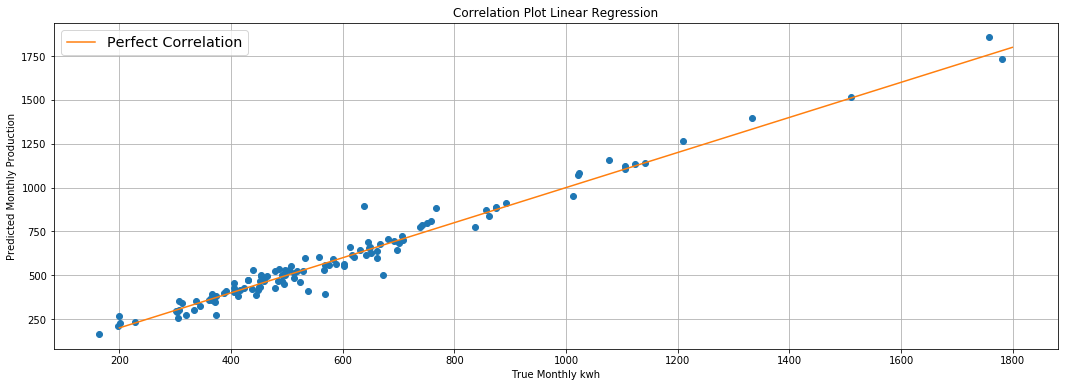

In [361]:
plt.figure(figsize=(18,6))
plt.title("Correlation Plot Linear Regression")
plt.ylabel("Predicted Monthly Production")
plt.xlabel("True Monthly kwh")
plt.plot(y_hat, y_test, 'o');
plt.plot(np.arange(200,1800,1),np.arange(200,1800,1), label="Perfect Correlation")
plt.grid()
plt.legend(fontsize="x-large");

On average, Linear Regression's monthly predictions of kWhs produced is off by 35 kwhs. 

The `True vs. Predicted` plot may be a bit misleading. The value being predicted is the 12th month energy production for a single system (i.e. panel). The model is given the first 11 months of energy production for each system. The plot shows what could be interpreted as a single series, but it's not. Each of those points exist in independent series. 

In [364]:
lasso = LassoCV(n_jobs=-1)
lasso.fit(x_train, y_train)
y_hat = lasso.predict(x_test)

In [365]:
# Lasso results
print(mean_squared_error(y_test, y_hat))
print(np.sqrt(mean_squared_error(y_test, y_hat)))
print(mean_absolute_error(y_test, y_hat))
print(r2_score(y_test, y_hat))

2602.175098063745
51.01151926833531
34.7823884838671
0.9712257435923657


In [366]:
ridge = RidgeCV(alphas=(0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0))
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [367]:
# Lasso results
print(mean_squared_error(y_test, y_hat))
print(np.sqrt(mean_squared_error(y_test, y_hat)))
print(mean_absolute_error(y_test, y_hat))
print(r2_score(y_test, y_hat))

2540.432088952182
50.402699222880734
35.661509320671236
0.971908483649665


We see that regularized regression performs about the same as standard regression. We'll stick with LR. 

### Save trained model to file

In [377]:
model_filename = "trained_model_production_forecast.pkl"
pickle.dump(lr, open(model_filename, 'wb'))

------
### Save all resutls to file

The market value prices for kwhs used are taken from here: 
[**Last 13 months average cost of kWh**](https://www.bls.gov/regions/west/news-release/averageenergyprices_sanfrancisco.htm)

Let's save data product data to file. 


### Save kWh Cost to File

In [382]:
# $ per kwh
# aug 2017 - aug 2018
kwh_cost = np.array([.210, .210, .210, .204, .204, \
            .205, .205, .212, .205, .211, \
            .211, .211])


kwh_cost_filename = "avg_monthly_kwh_cost.pkl"
pickle.dump(kwh_cost, open(kwh_cost_filename, 'wb'))

### Randomly Select 4 Systems and Save to File

In [383]:
n_select = 4 # num of systems to select
n_systems = len(x_test)  # num of systems
system_ids = [random.choice(range(n_systems)) for _ in range(n_select)]

# split that into first 11 months and the to-be-forecasted 12th month
choosen_systems_first_11_months = np.array(x_test)[system_ids]
choosen_systems_last_month = np.array(y_test)[system_ids]

energy_production_filename = "kwh_production_data.pkl"
pickle.dump([choosen_systems_first_11_months, choosen_systems_last_month], open(energy_production_filename, 'wb'))

### Split Consumption Data into Years and Save to file

In [384]:
years = ["2007", "2008", "2009", "2010"]
monthly_ave_consumption = []
for year in years:
    monthly_ave_consumption.append(monthlhy_mean[monthlhy_mean.year == year].Global_active_power.values)
    
energy_consumption_filename = "kwh_consumpton_data.pkl"
pickle.dump(monthly_ave_consumption, open(energy_consumption_filename, 'wb'))

------